# Q2
## 2.1

We have the 1D HMM:

\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; \theta x_{t-1}, Q) \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R)
\end{align*}

We know the exact marginal likelihood $Z_* = p(y_{1:T})$ is given by

$$
p(y_{1:T}) = \int p(x_{0:T}, y_{1:T}) dx_{0:T}
$$

$$
= \int \pi_0(x_0) \prod_{t=1}^T \bigg(\tau(x_t | x_{t-1}) g(y_t | x_t) \bigg) dx_{0:T}
$$

We also note that equivalently

$$
p(y_{1:T}) = \prod_{t=1}^T p(y_t \mid y_{1:t-1})
$$

Where

$$
p(y_t \mid y_{1:t-1}) = \int p(y_t \mid x_t) p(x_t \mid y_{1:t-1}) \, dx_t
$$

Since we have a fully Gaussian HMM setup, we can use Kalman filter to compute 
$p(x_t \mid y_{1:t-1}) =  \mathcal{N}(x_t; \hat{m}_t, \hat{P}_t)$, where

\begin{align*}
\hat{m}_t &= \theta m_{t-1} \\
\hat{P}_t &= \theta P_{t-1} \theta^\top + Q
\end{align*}

So that we have 

$$
p(y_t \mid y_{1:t-1}) = \int \mathcal{N}(y_t; H x_t, R) \cdot \mathcal{N}(x_t; \hat{m}_t, \hat{P}_t) \, dx_t
$$

By Lemma 3.2, this is

$$
p(y_t \mid y_{1:t-1}) = \mathcal{N}(H \hat{m}_t , H^2 \hat{P}_t + R) = \mathcal{N}(H \hat{m}_t , S_t)
$$

Where we let $S_t = H^2 \hat{P}_t + R$ for simplicity


The full algorithm for computing $\log p(y_{1:T}) = \sum_{t=1}^T \log p(y_t \mid y_{1:t-1})$ is given by

- Input:
Starting point $ m_0, P_0$, and the sequence of observations $ y_{1:T} $ for the specific T.

    Set $\hat{m}_0 = m_0, \hat{P}_0 = P_0$

- Filtering:  
**For** $ n = 1, \dots, T $ **do**
    - Prediction step:
    \begin{align*}
    \hat{m}_t &= \theta m_{t-1} \\
    \hat{P}_t &= \theta P_{t-1} \theta^\top + Q
    \end{align*}

    - Update step:
    \begin{align*}
    S_t &= H \hat{P}_t H^\top + R \\
    K_t &= \hat{P}_t H^\top (S_t)^{-1} \\
    m_t &= \hat{m}_t + K_t (y_t - H \hat{m}_t) \\
    P_t &= (I - K_t H) \hat{P}_t
    \end{align*}

    **End for**    

- Return $ \hat{m}_{1:T}, S_{1:T}$

And we output
$$
\log p(y_{1:T}) = \sum_{t=1}^T \log \mathcal{N}(y_t; H \hat{m}_{t}, S_t)
$$



## 2.2

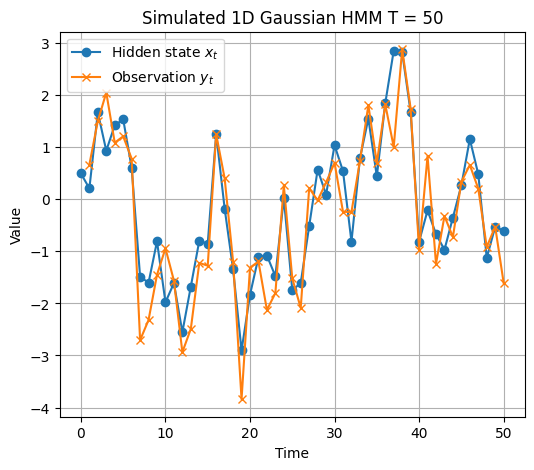

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)
theta = 0.7
Q = 1.0
R = 0.5
P0 = 1.0
m0 = 0.0
H = 1.0
T = 50

# Initialize arrays
def simulate_hmm_q2(theta, Q, R, P0, m0, H, T):
    x = np.zeros(T + 1)  # state: x_0 to x_T
    y = np.zeros(T)      # observations: y_1 to y_T

    # Initial state
    x[0] = np.random.normal(m0, np.sqrt(P0))

    # Simulate the HMM
    for t in range(1, T + 1):
        x[t] = np.random.normal(theta * x[t - 1], np.sqrt(Q))         # state evolution
        y[t - 1] = np.random.normal(H * x[t], np.sqrt(R))             # observation

    return x, y

### sanity check
x,y = simulate_hmm_q2(theta, Q, R, P0, m0, H, T)

# Plot results
plt.figure(figsize=(6, 5))
plt.plot(range(T + 1), x, label='Hidden state $x_t$', marker='o')
plt.plot(range(1, T + 1), y, label='Observation $y_t$', marker='x')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Simulated 1D Gaussian HMM T = 50')
plt.grid(True)
plt.show()


In [2]:
T_range = [10, 20, 50, 100, 200, 500, 1000]
q2_data = {}
for t in T_range:
    x, y = simulate_hmm_q2(theta, Q, R, P0, m0, H, t)
    q2_data[t] = (x, y)

In [3]:
def kalman_filter_loglik(y, theta, Q, R, H, m0, P0):
    """
    Computes log p(y_{1:T}) = sum_t log N(y_t; H m_hat_t, S_t)
    """
    T = len(y)
    
    # Initialize
    m_hat = m0
    P_hat = P0
    
    m_filtered = np.zeros(T)
    S = np.zeros(T)
    loglik = 0.0
    
    for t in range(T):
        # Prediction step
        m_hat = theta * m_hat
        P_hat = theta * P_hat * theta + Q
        
        # Update step
        S_t = H * P_hat * H + R
        K_t = P_hat * H / S_t
        m_t = m_hat + K_t * (y[t] - H * m_hat)
        P_t = (1 - K_t * H) * P_hat
        
        # Store results
        m_filtered[t] = m_hat
        S[t] = S_t
        
        # Increment log-likelihood
        loglik += -0.5 * (np.log(2 * np.pi * S_t) + ((y[t] - H * m_hat) ** 2) / S_t)
        
        # Prepare for next iteration
        m_hat = m_t
        P_hat = P_t

    return m_filtered, S, loglik


In [4]:
loglik_dict = {}
for t, (x, y) in q2_data.items():
    m_filtered, S, log_py = kalman_filter_loglik(y, theta, Q, R, H, m0, P0)
    loglik_dict[t] = log_py
    print(f"T = {t}, log p(y_{1}:{t}) = {log_py:.2f}")

T = 10, log p(y_1:10) = -16.83
T = 20, log p(y_1:20) = -28.84
T = 50, log p(y_1:50) = -88.47
T = 100, log p(y_1:100) = -164.51
T = 200, log p(y_1:200) = -331.26
T = 500, log p(y_1:500) = -837.67
T = 1000, log p(y_1:1000) = -1702.22


## 2.3

Again we have
$$
p(y_{1:n}) = p(y_{1:n-1}) p(y_n|y_{1:n-1})
$$

Where the conditional likelihood

$$
p(y_n|y_{1:n-1}) = \int g(y_n|x_n) p(x_n|y_{1:n-1}) \, \mathrm{d}x_n
$$

can be estimated by BPF:

$$
p^N(y_n|y_{1:n-1}) = \frac{1}{N} \sum_{i=1}^{N} g(y_n|\tilde{x}_n^{(i)})
$$

Where $\tilde{x}_n^{(i)}$ are the final resampled outputs of the BPF. So that the full marginal likelihood is given by

$$
p^N(y_{1:n}) = \prod_{k=1}^{t} p^N(y_k|y_{1:k-1})
$$

As we are working with the log domain, we have

\begin{align*}
\log p^N(y_n | y_{1:n-1}) =& \log \sum_{i=1}^{N} \exp\left( \log g(y_n | \tilde{x}_n^{(i)}) \right) - \log N, \\

=& \log \sum_{i=1}^{N} \exp\left( \log W_n^{(i)} \right) - \log N
\end{align*}

#### Pseudocode

Recall setup:

\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; \theta x_{t-1}, Q) \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R)
\end{align*}

The whole BPF pseudocode is given by

**Sample:**  
$ x_0^{(i)} \sim \pi_0 $ for $ i = 1, \ldots, N. $  

**for** $ t = 1, \ldots, T $ **do**

- Sample:
$ \bar{x}_t^{(i)} \sim \tau_{\theta}(\cdot|x_{t-1}^{(i)}) \quad \text{for} \quad i = 1, \ldots, N. $

- Weight:
$
W_t^{(i)} = g_{\theta}(y_t|\bar{x}_t^{(i)}),
$
for $ i = 1, \ldots, N $.

- Store:
$
p^N(y_n|y_{1:n-1}) = \frac{1}{N} \sum_{i=1}^{N} W_t^{(i)}
$

- Normalize
$
w_t^{(i)} = \frac{W_t^{(i)}}{\sum_{j=1}^{N} W_t^{(j)}},
$

- Resample: 
Sample $ o_t(1), \dots, o_t(N) \sim $ Multinomial( $w_t^{(1)}, \dots, w_t^{(N)}$ ),
and set $ x_t^{(i)} = \bar{x}_t^{(o_t(i))} $ for $ i = 1, \ldots, N $.

Return $p^N(y_{1:n}) = \prod_{k=1}^{t} p^N(y_k|y_{1:k-1})$






## 2.4 BPF Implementation

We reference our `log_p` function from Q1, and modify the `bpf` algo to store the average weight at each step, as our estimate of marginal likelihood at each step.

We also remove all the vectorizations, as all params are 1d in this question

In [5]:
def log_p(y, y_pred, R):
    '''y: scalar, y_pred: (N,), R: scalar variance'''
    diff = y_pred - y  # (N,)
    mahalanobis = (diff ** 2) / R  # (N,)
    log_det_R = np.log(R)
    
    log_likelihoods = -0.5 * (mahalanobis + np.log(2 * np.pi) + log_det_R)
    return log_likelihoods

def bpf_q2(Y, A, Q, H, R, m0, P0, N=500):
    T = len(Y)
    W = np.zeros((T, N))
    log_marginal_likelihood = 0.0
    
    # Step 1: init particles
    x = np.random.normal(loc=m0, scale=np.sqrt(P0), size=N)  # (N,)
    particle_history = []

    for t in range(T):
        # Step 2: Propagation
        noise = np.random.normal(loc=0.0, scale=np.sqrt(Q), size=N)
        x = A * x + noise  # (N,)
        
        # Step 3: Weight Update
        y = Y[t]
        y_pred = H * x  # (N,)
        log_w = log_p(y, y_pred, R)

        # compute average weight using log-sum-exp trick
        # log sum exp( log W) - log N
        max_log = np.max(log_w)
        log_sum = np.log(np.sum(np.exp(log_w - max_log))) + max_log
        log_marginal_likelihood += log_sum - np.log(N)

        # Normalize log-weights in log-domain
        # same as weights /= np.sum(weights)
        log_w -= np.log(np.sum(np.exp(log_w - np.max(log_w)))) + np.max(log_w)
        weights = np.exp(log_w)
        W[t] = weights
        
        # Step 4: Resampling
        indices = np.random.choice(N, size=N, p=weights)
        x = x[indices]
        particle_history.append(x.copy())
        
    return log_marginal_likelihood

Note to estimate this ratio, we note that when T = 200, both ratios are on 1e-133, and when T = 500, direct division is not feasible. 

Hence we use the log-sum-exp trick to compute the mean estimate for the likelihood over M simulations, and use $ \exp(\log Z_T^N - \log Z_T^*)$ to compute the ratio.

In [24]:
def estimate_likelihood_ratio(T_range, M=10, N=100, print_ = False):
    """
    For each T in T_range, run BPF M times, average the marginal likelihoods,
    and compare to the true likelihood from loglik_dict.
    Returns a dict mapping T to estimated ratio Z_T^N / Z_T_star.
    """
    ratio_dict = {}

    for T in T_range:
        Z_estimates = []

        # Run BPF M times
        for _ in range(M):
            _, y = q2_data[T]
            log_Z = bpf_q2(y, A=theta, Q=Q, H=H, R=R, m0=m0, P0=P0, N=N)
            Z_estimates.append(log_Z)

        # compute average weight estimation over M simulations
        # log sum exp( log Z) - log M
        max_log_Z = np.max(log_Z)
        log_sum = np.log(np.sum(np.exp(Z_estimates - max_log_Z))) + max_log_Z
        log_Z_T_N = log_sum - np.log(M)
        Z_T_N = np.exp(log_Z_T_N)
        if print_:
            print(f"T = {T}, log Z_T^N = {log_Z_T_N}")
            print('true log likelihood = ', loglik_dict[T])

        # Compute and store ratio
        # ratio_dict[T] = Z_T_N / Z_T_star 
        # = exp(log_Z_T_N - log_Z_T_star)
        ratio_dict[T] = np.exp(log_Z_T_N - loglik_dict[T])

    return ratio_dict

print("sanity check for M = 10, N = 100")
ratio_dict = estimate_likelihood_ratio(T_range, M=10, N=100, print_=True)
for T in T_range:
    print(f"T = {T}: Z_T^N / Z_T* ≈ {ratio_dict[T]:.4f}")

sanity check for M = 10, N = 100
T = 10, log Z_T^N = -16.751109129142556
true log likelihood =  -16.833016254062088
T = 20, log Z_T^N = -28.687348117045353
true log likelihood =  -28.84283492398628
T = 50, log Z_T^N = -88.35637393342631
true log likelihood =  -88.46658617905523
T = 100, log Z_T^N = -165.27820495057165
true log likelihood =  -164.51115620427242
T = 200, log Z_T^N = -332.1634503881409
true log likelihood =  -331.25922331503455
T = 500, log Z_T^N = -839.2334457948804
true log likelihood =  -837.6748190903836
T = 1000, log Z_T^N = -1712.0405717729589
true log likelihood =  -1702.2220779322422
T = 10: Z_T^N / Z_T* ≈ 1.0854
T = 20: Z_T^N / Z_T* ≈ 1.1682
T = 50: Z_T^N / Z_T* ≈ 1.1165
T = 100: Z_T^N / Z_T* ≈ 0.4644
T = 200: Z_T^N / Z_T* ≈ 0.4049
T = 500: Z_T^N / Z_T* ≈ 0.2104
T = 1000: Z_T^N / Z_T* ≈ 0.0001


We now fix N = 100, run estimation for each T using M = 1e1 to 1e5

This takes around 30 minutes to run, so I save the data as a dictionary using pickle

In [ ]:
import os
import pickle

if os.path.exists("ratio_dict_M.pkl"):
    # load the ratio data for each M
    with open("ratio_dict_M.pkl", "rb") as f:
        ratio_dict_M = pickle.load(f)

else:
    # run estimation for each M, takes a long time
    M_range = [1, 10, 100, 1000, 10000]
    ratio_dict_M = {}
    for M in M_range:
        ratio_dict_M[M] = estimate_likelihood_ratio(T_range, M=M, N=100)

    # save the ratio_dict_M to a file
    with open("ratio_dict_M.pkl", "wb") as f:
        pickle.dump(ratio_dict_M, f)
        print("Saved ratio_dict_M to ratio_dict_M.pkl")




In [19]:
M_range = [1, 10, 100, 1000, 10000]
ratio_dict_M = {}
for M in M_range:
    ratio_dict_M[M] = estimate_likelihood_ratio(M=M, N=100)

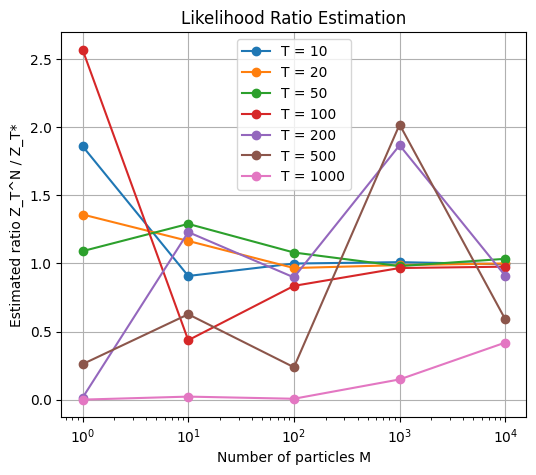

In [20]:
plot_data = {}
for T in T_range:
    plot_data[T] = [ratio_dict_M[M][T] for M in M_range]

# plot_data[10]
plt.figure(figsize=(6, 5))
for T in T_range:
    plt.plot(M_range, plot_data[T], label=f"T = {T}", marker='o')
plt.xscale('log')
plt.xlabel("Number of particles M")
plt.ylabel("Estimated ratio Z_T^N / Z_T*")
plt.title("Likelihood Ratio Estimation")
plt.legend()
plt.grid(True)
plt.show()

We can see that with smaller T, the ratio quickly converges to 1, while it takes larger M to converge fot T = 500 and T = 1000. For T $\leq$ 100, we can see M = 1000 provides a very good estimate already, but for T = 500, we can see very large variance in the ratio around 1, and for T = 1000, M = $10^4$ is still not enough, but we can see the ratio increasing from 0 to 0.5, so we expect a larger M could provide a better estimate. We should choose larger M as T grows.

### 2.4 (b)

We now fix T = 500, and run the estimation for different N

In [26]:
import os
import pickle

M_range = [1, 10, 100, 1000] # ignore 10000 for taking too long

if os.path.exists("ratio_dict_N.pkl"):
    # load the ratio data for each N
    with open("ratio_dict_N.pkl", "rb") as f:
        ratio_dict_N = pickle.load(f)

else:
    # run estimation for each N, takes a long time
    N_range = [100, 500, 1000, 2000, 4000, 6000, 8000, 10000]
    ratio_dict_N = {}
    for N in N_range:
        ratio_dict_N[N] = []
        for M in M_range:
            ratio_dict_N[N].append(estimate_likelihood_ratio(T_range=[500], M=M, N=N))
            print(f"N = {N}, M = {M} done")
            

    # save the ratio_dict_N to a file
    with open("ratio_dict_N.pkl", "wb") as f:
        pickle.dump(ratio_dict_N, f)
        print("Saved ratio_dict_N to ratio_dict_N.pkl")




N = 100, M = 1 done
N = 100, M = 10 done
N = 100, M = 100 done
N = 100, M = 1000 done
N = 500, M = 1 done
N = 500, M = 10 done
N = 500, M = 100 done
N = 500, M = 1000 done
N = 1000, M = 1 done
N = 1000, M = 10 done
N = 1000, M = 100 done
N = 1000, M = 1000 done
N = 2000, M = 1 done
N = 2000, M = 10 done
N = 2000, M = 100 done
N = 2000, M = 1000 done
N = 4000, M = 1 done
N = 4000, M = 10 done
N = 4000, M = 100 done
N = 4000, M = 1000 done
N = 6000, M = 1 done
N = 6000, M = 10 done
N = 6000, M = 100 done
N = 6000, M = 1000 done
N = 8000, M = 1 done
N = 8000, M = 10 done
N = 8000, M = 100 done
N = 8000, M = 1000 done
N = 10000, M = 1 done
N = 10000, M = 10 done
N = 10000, M = 100 done
N = 10000, M = 1000 done
Saved ratio_dict_N to ratio_dict_N.pkl


#### Impact of N on convergence w.r.t. M for fixed T = 500

Larger N needs smaller M to aproahc 1



## 2.5 Estimating Params with NPF 

Recall setup:

\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; \theta x_{t-1}, Q) \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R)
\end{align*}

We re-use our old setup:

\begin{align*}
\theta^* = 0.7,
Q = 1.0,
R = 0.5,
P0 = 1.0,
m0 = 0.0,
H = 1.0,
T = 1000
\end{align*}

and the data generated from 2.2: `q2_data[T] = (x, y)`

#### NPF pseudocode

Let prior $p_0(\theta) = \text{Unif}(-1, 1)$

**Sample:**  $ \hat{\theta}_0^{(i)} \sim p_0$ 
for $ i = 1, \ldots, M $.


**for** $ t = 1, \ldots, T $ **do**

- Propose 
$ \hat{\theta}_t^{(i)} \sim \kappa(\cdot|\theta_{t-1}^{(i)}) \quad \text{for} \quad i = 1, \ldots, M. $

- Sample Inner layer:
$ \bar{x}_t^{(i, j)} \sim \tau_{\hat{\theta}_t^{(i)}}(\cdot|x_{t-1}^{(i, j)}) \quad \text{for} \quad j = 1, \ldots, N,
\quad \text{for} \quad i = 1, \ldots, M. $

- Weight:
$
V_t^{(i, j)} = g_{\hat{\theta}_t^{(i, j)}}(y_t|\bar{x}_t^{(i, j)}),
\quad \text{for} \quad j = 1, \ldots, N,
\quad \text{for} \quad i = 1, \ldots, M $.

- Normalize
$
v_t^{(i,j)} = \frac{V_t^{(i,j)}}{\sum_{j=1}^N V_t^{(i,j)}},
$

- Approximate outler layer:
$
W_t^{(i)} = \frac{1}{N} \sum_{j=1}^N v_t^{(i,j)}
$

- Normalize
$
w_t^{(i)} = \frac{W_t^{(i)}}{\sum_{j=1}^M W_t^{(j)}},
\quad \text{for} \quad i = 1, \ldots, M 
$

- Resample Inner particles
$
\tilde{x}_t^{(i,j)} \sim \sum_{j=1}^N v_t^{(i,j)} \delta_{\bar{x}_t^{(i,j)}}, 
\quad \text{for} \quad j = 1, \ldots, N,
\quad \text{for} \quad i = 1, \ldots, M 
$

- Resample
Sample $ o_t(1), \dots, o_t(N) \sim $ Multinomial( $w_t^{(1)}, \dots, w_t^{(M)}$ ),
and set 

\begin{align*}
\theta_t^{(i)} =& \hat{\theta}_t^{(o_t(i))}\\
x_t^{(i,j)} =& \bar{x}_t^{(o_t(i), j)}
\end{align*}

for $ j = 1, \ldots, N $.

Return $ \{\theta_T^{(i)}\}_{i=1}^M$, and approximate posterior by 

$$
p(\mathrm{d}\theta|y_{1:T}) \approx \frac{1}{M} \sum_{i=1}^M \delta_{\theta_T^{(i)}}(\mathrm{d}\theta)
$$

In [27]:
def npf_q2(Y, Q, R, m0, P0, H=1.0, M=100, N=100, proposal_std=0.05):
    T = len(Y)
    thetas = np.random.uniform(-1, 1, size=M)  # Initial samples from p0(theta)
    theta_particles = np.zeros((T, M))
    
    # Initialize inner particles for each outer particle
    x_particles = np.random.normal(loc=m0, scale=np.sqrt(P0), size=(M, N))
    
    for t in range(T):
        y = Y[t]
        
        # Step 1: Propose new theta from some proposal kernel (e.g., Gaussian RW)
        theta_proposed = thetas + np.random.normal(loc=0.0, scale=proposal_std, size=M)

        # Step 2: Propagate inner particles using each theta
        x_bar = np.zeros((M, N))
        for i in range(M):
            noise = np.random.normal(0, np.sqrt(Q), size=N)
            x_bar[i] = theta_proposed[i] * x_particles[i] + noise  # shape (N,)
        
        # Step 3: Weight update using likelihood
        log_weights_inner = np.zeros((M, N))
        for i in range(M):
            y_pred = H * x_bar[i]
            log_weights_inner[i] = log_p(y, y_pred, R)

        # Step 4: Normalize inner weights (log domain for stability)
        v = np.zeros((M, N))
        for i in range(M):
            max_log = np.max(log_weights_inner[i])
            log_sum = np.log(np.sum(np.exp(log_weights_inner[i] - max_log))) + max_log
            log_weights_inner[i] -= log_sum  # log-normalize
            v[i] = np.exp(log_weights_inner[i])  # normalized weights
        
        # Step 5: Compute outer weights as average inner weights
        W = np.mean(v, axis=1)  # shape (M,)
        W /= np.sum(W)  # normalize outer weights

        # Step 6: Resample inner particles according to v
        x_tilde = np.zeros((M, N))
        for i in range(M):
            indices = np.random.choice(N, size=N, p=v[i])
            x_tilde[i] = x_bar[i][indices]

        # Step 7: Resample outer particles according to W
        o = np.random.choice(M, size=M, p=W)
        thetas = theta_proposed[o]              # Resample thetas
        x_particles = x_tilde[o]                # Resample inner particles
        theta_particles[t] = thetas             # Store thetas over time

    return theta_particles[-1]  # Return final samples of theta_T^{(i)}
